In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
from scipy.signal import savgol_filter, detrend, find_peaks
from scipy.special import voigt_profile, wofz
from scipy.stats import cauchy, norm
from sklearn.ensemble import IsolationForest
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import shuffle
from lmfit.models import ExponentialModel, VoigtModel, ConstantModel

In [3]:
from boxsers.preprocessing import savgol_smoothing, als_baseline_cor, spectral_normalization, spectral_cut, rubberband_baseline_cor

In [4]:
# sns.set_style('whitegrid')
# plt.rcParams['font.family'] = 'Arial'
# plt.rcParams['font.size'] = 12

294


<Axes: >

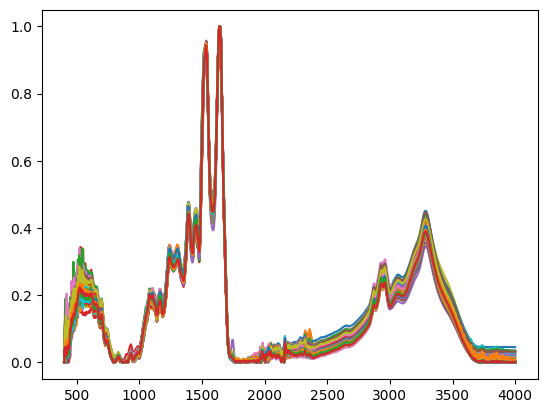

In [18]:
import pandas as pd
from scipy.signal import find_peaks

domain = pd.read_csv('../data/domain.csv')
df = pd.read_csv('../data/dataset.csv')
max_abs = df.drop(columns=['HbA1c', 'years']).apply(lambda row: True if row.max() > 0.30 else False, axis=1)
df = df[max_abs]

df = df.drop(columns='years')
print(len(df))

X_raw = df.drop(columns='HbA1c')
X_raw.columns = np.ravel(domain)
#X = X.apply(lambda row: row / row.max(), axis=1)
X = X_raw.T.apply(lambda col: np.ravel(rubberband_baseline_cor(col))).T
X = X.T.apply(lambda col: savgol_filter(col, window_length=5, polyorder=3)).T
X = X.apply(lambda row: row / row.max(), axis=1)
#X = X_raw.apply(lambda row: row / np.linalg.norm(row), axis=1)

y = df['HbA1c']
X.T.plot(legend=False)

(1000.0, 1700.0)

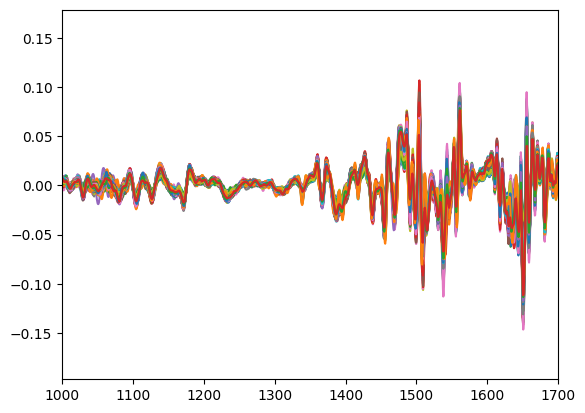

In [6]:
X_deriv = X_raw.T.apply(lambda col: savgol_filter(col, window_length=20, polyorder=2, deriv=2)).T
X_deriv = X_deriv.apply(lambda row: row / np.linalg.norm(row), axis=1)
X_deriv.T.plot(legend=False)
plt.xlim([1000, 1700])


$$V(x; x_0, \sigma, \gamma, A) = \frac{A}{\sigma\sqrt{2\pi}} \int_{-\infty}^{\infty} e^{-\frac{(x - x')^2}{2\sigma^2}} \frac{\gamma}{\pi((x' - x_0)^2 + \gamma^2)} dx'$$

In [7]:
def create_params(x_values, y_values, peaks):
    params = {}

    for i, peak in enumerate(peaks):
        params.update({
            f"v{i+1}amplitude": dict(value=y_values[peak], min=0, vary=True),
            f"v{i+1}center": dict(value=x_values[peak], min=x_values[peak] - 5, max=x_values[peak] + 5, vary=True),
            f"v{i+1}sigma": dict(value=5, min=0, vary=True),
            f"v{i+1}gamma": dict(value=5, min=0, vary=True)
        })
    
    return params
        

def fit_voigt(x_values, y_values, peaks, peak_names=None):
    peaks = [np.where(x_values == value)[0][0] for value in peaks]
    
    params_dict = create_params(x_values, y_values, peaks)
    
    model_names = []

    composite_model = None
    
    for i, peak in enumerate(peaks):
        if peak_names:
            model_name = str(peak_names[i])
        else:
            model_name = f"v{i+1}"
        
        voigt_model = VoigtModel(prefix=model_name)

        if not composite_model:
            composite_model = voigt_model
            model_names.append(model_name)
        else:
            composite_model += voigt_model
            model_names.append(model_name)

    params = composite_model.make_params(**params_dict)
    result = composite_model.fit(y_values, params, x=x_values)

    fitted_params = result.params
    # for param_name, param in fitted_params.items():
    #     print(param_name, param.value)

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=x_values, y=y_values, mode='lines', name='Absorbance'))
    fig.add_trace(go.Scatter(x=x_values, y=result.best_fit, mode='lines', name='Best fit', line=dict(color='black')))
    fig.add_trace(go.Scatter(
        x=x_values[peaks],
        y=y_values[peaks],
        mode='markers',
        name='Peaks',
        marker=dict(size=8, color='red'),
        visible='legendonly'
    ))

    comp = result.eval_components(x=x_values)
    
    for key, values in comp.items():
        fig.add_trace(go.Scatter(x=x_values, 
                                 y=values, 
                                 mode='lines', 
                                 line=dict(width=1, dash='dash'),
                                name=key))
            

    fig.update_layout(title='Voigt fit', 
                      xaxis_title='Wavenumber', 
                      yaxis_title='Absorbance', 
                      height=650, 
                      width=950
    )
    
    return result, fig

In [8]:
peaks = pd.read_csv("../data/peaks.csv")
peaks

,1005-1014,1022-1035,1036-1048,1050-1060,1070-1090,1100-1110,1120-1130,1140-1160,1165-1180,1185-1215,...,1650-1654,1655-1657,1659-1663,1665-1670,1672-1675,1678-1680,1681-1685,1686-1689,1693-1696,1698-1700
0,1012.462,1029.336,1047.657,1050.067,1079.959,1105.030,1126.243,1159.992,1169.634,1204.829,...,1652.241,1656.098,1660.437,1667.669,1674.419,1678.758,1683.097,1687.436,1694.668,1699.007
1,1011.497,1028.854,1047.657,1054.406,1081.888,1105.030,1125.761,1159.992,1169.634,1204.829,...,1652.241,1656.098,1660.919,1667.669,1674.419,1678.758,1683.097,1687.436,1694.668,1699.007
2,1013.426,1029.818,1047.657,1051.996,1081.888,1104.547,1125.761,1158.063,1169.152,1206.758,...,1652.241,1656.098,1660.437,1667.669,1674.419,1678.758,1683.097,1687.436,1694.668,1699.007
3,1011.015,1029.336,1047.657,1050.550,1080.441,1104.547,1125.761,1159.992,1169.634,1205.312,...,1652.241,1656.098,1660.437,1667.669,1674.419,1678.758,1683.097,1687.436,1694.668,1699.007
4,1012.944,1030.300,1047.657,1050.067,1079.959,1105.030,1125.279,1157.581,1169.152,1204.347,...,1652.241,1656.098,1660.919,1667.669,1673.937,1678.758,1683.097,1687.436,1694.668,1699.007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,1011.497,1029.336,1047.657,1050.067,1080.441,1105.030,1126.243,1158.063,1169.634,1206.758,...,1652.241,1656.098,1660.437,1667.669,1674.419,1678.758,1683.097,1687.436,1694.668,1699.007
290,1011.980,1028.372,1047.657,1051.514,1079.477,1105.030,1126.243,1159.510,1169.634,1206.758,...,1652.241,1656.098,1660.437,1667.669,1674.419,1679.240,1683.097,1687.436,1694.668,1699.007
291,1011.015,1029.336,1047.657,1051.032,1080.923,1105.030,1126.243,1159.992,1169.634,1207.722,...,1652.241,1656.098,1661.401,1668.151,1674.419,1679.240,1683.579,1688.400,1694.668,1699.489
292,1011.980,1029.336,1047.657,1050.067,1079.477,1105.030,1125.761,1158.063,1169.634,1204.347,...,1652.241,1656.098,1660.437,1667.669,1674.419,1678.758,1683.097,1687.436,1694.668,1699.007


In [9]:
# %%time
# sample_raw = X.iloc[0, 1250:2700]
# x_values = sample_raw.index.to_numpy()
# y_values = sample_raw.to_numpy()
# idx = peaks.iloc[0]
# res, fig = fit_voigt(x_values, y_values, idx)

,1575.101,1575.583,1576.065,1576.547,1577.03,1577.512,1577.994,1578.476,1578.958,1579.44,...,1695.632,1696.114,1696.596,1697.079,1697.561,1698.043,1698.525,1699.007,1699.489,1699.971
0,1.321525e-06,0.000692,0.001366,0.002169,0.003173,0.004284,0.005314,0.006121,0.006691,0.007145,...,0.054184,0.044493,0.036328,0.030367,0.026287,0.023120,0.019674,0.014865,0.008299,-0.000015
1,1.307907e-05,0.000177,0.000078,-0.000082,0.000081,0.000743,0.001931,0.003209,0.004317,0.005246,...,0.055141,0.044003,0.034808,0.028641,0.025096,0.022812,0.020167,0.015722,0.008978,-0.000020
2,5.028077e-07,0.000120,0.000003,0.000019,0.000489,0.001459,0.002680,0.003828,0.004768,0.005546,...,0.056168,0.045898,0.037432,0.031638,0.028097,0.025563,0.022511,0.017514,0.010017,-0.000020
3,3.511009e-06,0.000113,0.000021,-0.000021,0.000320,0.001167,0.002392,0.003643,0.004743,0.005702,...,0.057025,0.045933,0.036883,0.030671,0.026854,0.024205,0.021227,0.016520,0.009481,-0.000018
4,2.075053e-05,0.000280,0.000125,-0.000089,0.000023,0.000762,0.002409,0.004594,0.006762,0.008694,...,0.062375,0.050708,0.041133,0.034555,0.030507,0.027630,0.024253,0.018820,0.010736,-0.000021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,4.823635e-06,0.000141,0.000079,-0.000003,-0.000006,0.000105,0.000327,0.000560,0.000690,0.000766,...,0.055149,0.045475,0.037380,0.031469,0.027399,0.024205,0.020690,0.015729,0.008853,-0.000015
290,1.422447e-07,0.000206,0.000144,0.000050,0.000107,0.000355,0.000683,0.000960,0.001137,0.001291,...,0.053918,0.044491,0.036517,0.030630,0.026542,0.023353,0.019918,0.015144,0.008542,-0.000014
291,-4.548869e-06,0.002081,0.002822,0.002579,0.001797,0.000968,0.000360,0.000060,-0.000017,-0.000013,...,0.046263,0.038911,0.032155,0.026883,0.023213,0.020576,0.017967,0.014184,0.008384,-0.000012
292,6.292499e-06,0.000378,0.000233,0.000032,-0.000045,0.000038,0.000343,0.000874,0.001421,0.001894,...,0.055520,0.045545,0.037200,0.031206,0.027235,0.024257,0.020965,0.016108,0.009151,-0.000016


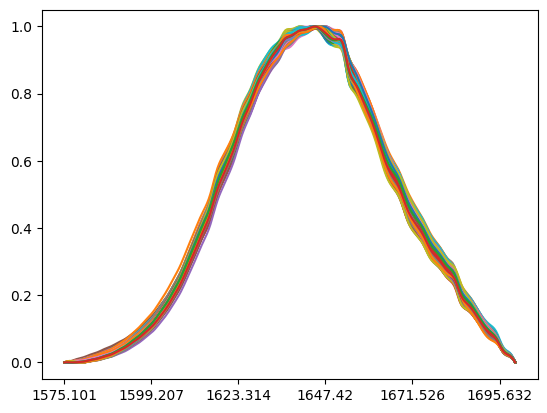

In [28]:
X_amide1 = pd.read_csv("../data/X_amide_1.csv")
X_amide1.T.plot(legend=False)
X_amide1

In [23]:
peaks_1580_1700 = pd.read_csv("../data/peaks_1580_1700.csv")
peaks_1580_1700

,1581-1584,1585-1587,1588-1592,1600-1603,1604-1606,1608-1610,1611-1614,1616-1619,1622-1626,1627-1630,...,1650-1654,1655-1657,1659-1663,1665-1670,1672-1675,1678-1680,1681-1685,1686-1689,1693-1696,1698-1700
0,1582.815,1586.19,1590.047,1601.618,1605.475,1609.332,1612.707,1617.528,1624.278,1628.617,...,1652.241,1656.098,1660.437,1667.669,1674.419,1678.758,1683.097,1687.436,1694.668,1699.007
1,1582.333,1586.19,1590.047,1601.618,1604.993,1609.332,1612.707,1617.528,1624.278,1628.617,...,1652.241,1656.098,1660.919,1667.669,1674.419,1678.758,1683.097,1687.436,1694.668,1699.007
2,1582.333,1586.19,1590.047,1601.618,1605.475,1609.332,1612.707,1617.528,1624.278,1628.617,...,1652.241,1656.098,1660.437,1667.669,1674.419,1678.758,1683.097,1687.436,1694.668,1699.007
3,1582.333,1586.19,1590.047,1601.618,1605.475,1609.332,1613.189,1617.528,1624.278,1628.617,...,1652.241,1656.098,1660.437,1667.669,1674.419,1678.758,1683.097,1687.436,1694.668,1699.007
4,1582.333,1586.19,1590.047,1601.618,1605.475,1609.332,1613.189,1617.528,1624.760,1628.617,...,1652.241,1656.098,1660.919,1667.669,1673.937,1678.758,1683.097,1687.436,1694.668,1699.007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,1582.333,1586.19,1590.047,1601.618,1605.475,1609.332,1612.707,1617.528,1624.278,1628.617,...,1652.241,1656.098,1660.437,1667.669,1674.419,1678.758,1683.097,1687.436,1694.668,1699.007
290,1582.333,1586.19,1590.047,1601.618,1605.475,1609.332,1612.707,1617.528,1624.278,1629.099,...,1652.241,1656.098,1660.437,1667.669,1674.419,1679.240,1683.097,1687.436,1694.668,1699.007
291,1582.333,1586.19,1590.047,1601.618,1605.475,1609.332,1612.707,1617.046,1624.278,1628.617,...,1652.241,1656.098,1661.401,1668.151,1674.419,1679.240,1683.579,1688.400,1694.668,1699.489
292,1582.333,1586.19,1590.047,1601.618,1605.475,1609.332,1613.189,1617.528,1624.278,1628.617,...,1652.241,1656.098,1660.437,1667.669,1674.419,1678.758,1683.097,1687.436,1694.668,1699.007


In [29]:
sample_raw = X_amide1.iloc[0]
x_values = sample_raw.index.to_numpy()
y_values = sample_raw.to_numpy()
idx = peaks_1580_1700.iloc[0]
res, fig = fit_voigt(x_values, y_values, idx.to_numpy())

IndexError: index 0 is out of bounds for axis 0 with size 0